### Node Classification

In [1]:
import dgl.nn as dglnn 
import dgl 
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from dgl.data import * 
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt 

Using backend: pytorch


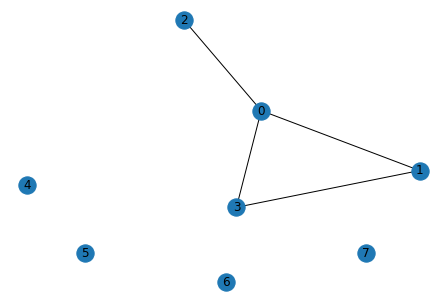

In [2]:

# 边 0->1, 0->2, 0->3, 1->3
u, v = torch.tensor([0, 0, 0, 1]), torch.tensor([1, 2, 3, 3])
g = dgl.graph((u, v))
g = dgl.graph((u, v), num_nodes=8)
g.ndata['feat'] = torch.eye(8)
nx_g = g.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True)



In [3]:
cora_dataset = CoraGraphDataset()
cora_graph = cora_dataset[0]
cora_graph = dgl.remove_self_loop(cora_graph)
cora_node_features = cora_graph.ndata['feat']
cora_node_labels = cora_graph.ndata['label']
cora_train_mask = cora_graph.ndata['train_mask']
cora_valid_mask = cora_graph.ndata['val_mask']
cora_test_mask = cora_graph.ndata['test_mask']
cora_n_features = cora_node_features.shape[1]
cora_n_labels = int(cora_node_labels.max().item() + 1) 

cite_dataset = CiteseerGraphDataset()
cite_graph = cite_dataset[0]
cite_graph = dgl.remove_self_loop(cite_graph)
cite_node_features = cite_graph.ndata['feat']
cite_node_labels = cite_graph.ndata['label']
cite_train_mask = cite_graph.ndata['train_mask']
cite_valid_mask = cite_graph.ndata['val_mask']
cite_test_mask = cite_graph.ndata['test_mask']
cite_n_features = cite_node_features.shape[1]
cite_n_labels = int(cite_node_labels.max().item() + 1) 

pubm_dataset = PubmedGraphDataset()
pubm_graph = pubm_dataset[0]
pubm_graph = dgl.remove_self_loop(pubm_graph)
pubm_node_features = pubm_graph.ndata['feat']
pubm_node_labels = pubm_graph.ndata['label']
pubm_train_mask = pubm_graph.ndata['train_mask']
pubm_valid_mask = pubm_graph.ndata['val_mask']
pubm_test_mask = pubm_graph.ndata['test_mask']
pubm_n_features = pubm_node_features.shape[1]
pubm_n_labels = int(pubm_node_labels.max().item() + 1) 

print(pubm_test_mask.shape)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
torch.Size([19717])


In [4]:
# G = cora_graph.to_networkx() 
# # res = np.random.randint(0, high=G.number_of_nodes(), size=(1000))
# print(cora_test_mask.sum())
# res = []
# for i in range(cora_graph.num_nodes()):
#     if cora_test_mask[i]:
#         res.append(i)
# k = G.subgraph(res) 
# print(k.number_of_nodes())
# pos = nx.spring_layout(k)

# plt.figure()
# nx.draw(k, pos=pos, node_size=8 )
# plt.savefig('cora.jpg', dpi=600)
# plt.show()

In [5]:
class GCN(nn.Module):
    def __init__(self, in_feats, n_layers, hid_feats, out_feats, aggregator_type, dropout):
        super(GCN, self).__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(dglnn.GraphConv(in_feats, hid_feats, aggregator_type, dropout, allow_zero_in_degree = True))
        
        for i in range(n_layers - 1):
            self.layers.append(dglnn.GraphConv(hid_feats, hid_feats, aggregator_type, dropout, allow_zero_in_degree = True))
        
        self.layers.append(dglnn.GraphConv(hid_feats, out_feats, aggregator_type, dropout, allow_zero_in_degree = True))
    
    def forward(self, graph, features): #节点特征 [N, in_feas]
        h = features
        for layer in self.layers:
            h = layer(graph, h)
        return h
    

class SAGE(nn.Module):
    def __init__(self, in_feats, n_layers, hid_feats, out_feats, aggregator_type, dropout):
        super(SAGE, self).__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(dglnn.SAGEConv(in_feats, hid_feats, aggregator_type, dropout))
        
        for i in range(n_layers - 1):
            self.layers.append(dglnn.SAGEConv(hid_feats, hid_feats, aggregator_type, dropout))
        
        self.layers.append(dglnn.SAGEConv(hid_feats, out_feats, aggregator_type, dropout))
    
    def forward(self, graph, features): #节点特征 [N, in_feas]
        h = features
        for layer in self.layers:
            h = layer(graph, h)
        return h
    
    
class GCN_JKN(nn.Module):
    def __init__(self, in_feats, n_layers, hid_feats, out_feats, aggregator_type, dropout):
        super(GCN_JKN, self).__init__()
        
        self.layers = nn.ModuleList()
        
#         self.layers.append(dglnn.GraphConv(in_feats, hid_feats, aggregator_type, dropout, allow_zero_in_degree = True))
        self.layers.append(dglnn.SAGEConv(in_feats, hid_feats, aggregator_type, dropout))
        
        for i in range(n_layers - 1):
#             self.layers.append(dglnn.GraphConv(hid_feats, hid_feats, aggregator_type, dropout, allow_zero_in_degree = True))
            self.layers.append(dglnn.SAGEConv(hid_feats, hid_feats, aggregator_type, dropout))
        
        self.last_layer = nn.Linear(hid_feats, out_feats)
    
    def forward(self, graph, features): #节点特征 [N, in_feas]
        
        layer_outputs = []
        for layer in self.layers:
            features = layer(graph, features)
            layer_outputs.append(features)
        h = torch.stack(layer_outputs, dim=0)
        h = torch.max(h, dim=0)[0]
        return self.last_layer(h)
    


In [6]:
def evaluate(model, graph, features, labels, mask):
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        values, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return indices, correct / len(labels)

In [9]:
def train(model, graph, node_features, node_labels, train_mask, valid_mask, num_iters):
    optimizer = torch.optim.Adam(model.parameters())
    best_acc = 0
    loss_history = []
    for i in range(num_iters): 
        print('Epoch {}'.format(i))
        logits = model(graph, node_features)
        loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
        loss_history.append(loss)
        pre, cur_acc = evaluate(model, graph, node_features, node_labels, valid_mask)

        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('loss = %0.3f' % loss)
        if cur_acc > best_acc:
            best_acc = cur_acc
            torch.save(model.state_dict(), 'best_model.pth')
        print("current val acc = %0.3f, best val acc = %0.3f" % (cur_acc, best_acc))

Color_Map = {
    0 : 'blue',
    1 : 'yellow',
    2 : 'red',
    3 : 'green',
    4 : 'orange',
    5 : 'purple',
    6 : 'pink',
}
        
def test(model, graph, node_features, node_labels, test_mask):
    model.load_state_dict(torch.load("best_model.pth"))
    pre, acc = evaluate(model, graph, node_features, node_labels, test_mask)
    color_map = []
    num = pre.numpy()
    for i in range(test_mask.sum()):
        color_map.append(Color_Map[num[i]])
    G = graph.to_networkx() 
    res = []
    for i in range(graph.num_nodes()):
        if test_mask[i]:
            res.append(i)
    k = G.subgraph(res) 
    print(k.number_of_nodes())
    pos = nx.circular_layout(k)
    plt.figure()
    nx.draw(k, pos=pos, node_size=8, node_color=color_map)
    plt.savefig('test.jpg', dpi=600)
    plt.show()
    print("test accuracy: ", acc)

In [10]:
#Baseline
def main(graph, node_features, node_labels, train_mask, valid_mask, test_mask, n_features, n_labels):
#     graph = dgl.add_self_loop(graph)
    GCN_model = GCN(in_feats = n_features, 
                 n_layers = 2, 
                 hid_feats = 100, 
                 out_feats = n_labels, 
                 aggregator_type = 'both', 
                 dropout = 0.5)

    #SAGE
    SAGE_model = SAGE(in_feats = n_features, 
                 n_layers = 2, 
                 hid_feats = 100, 
                 out_feats = n_labels, 
                 aggregator_type = 'mean', 
                 dropout = 0.5)

    #GCN & JKN
    GCN_JKN_model = GCN_JKN(in_feats = n_features, 
                 n_layers = 6, 
                 hid_feats = 100, 
                 out_feats = n_labels, 
                 aggregator_type = 'mean', 
                 dropout = 0.5)
    train(GCN_model, graph, node_features, node_labels, train_mask, valid_mask, num_iters = 100)
    test(GCN_model, graph, node_features, node_labels, test_mask)
    train(SAGE_model, graph, node_features, node_labels, train_mask, valid_mask, num_iters = 100)
    test(SAGE_model, graph, node_features, node_labels, test_mask)
    train(GCN_JKN_model, graph, node_features, node_labels, train_mask, valid_mask, num_iters = 100)
    test(GCN_JKN_model, graph, node_features, node_labels, test_mask)

Epoch 0
loss = 1.945
current val acc = 0.176, best val acc = 0.176
Epoch 1
loss = 1.940
current val acc = 0.188, best val acc = 0.188
Epoch 2
loss = 1.936
current val acc = 0.188, best val acc = 0.188
Epoch 3
loss = 1.931
current val acc = 0.192, best val acc = 0.192
Epoch 4
loss = 1.926
current val acc = 0.178, best val acc = 0.192
Epoch 5
loss = 1.921
current val acc = 0.180, best val acc = 0.192
Epoch 6
loss = 1.916
current val acc = 0.178, best val acc = 0.192
Epoch 7
loss = 1.911
current val acc = 0.180, best val acc = 0.192
Epoch 8
loss = 1.905
current val acc = 0.186, best val acc = 0.192
Epoch 9
loss = 1.899
current val acc = 0.188, best val acc = 0.192
Epoch 10
loss = 1.893
current val acc = 0.198, best val acc = 0.198
Epoch 11
loss = 1.887
current val acc = 0.206, best val acc = 0.206
Epoch 12
loss = 1.880
current val acc = 0.218, best val acc = 0.218
Epoch 13
loss = 1.872
current val acc = 0.236, best val acc = 0.236
Epoch 14
loss = 1.865
current val acc = 0.280, best val ac

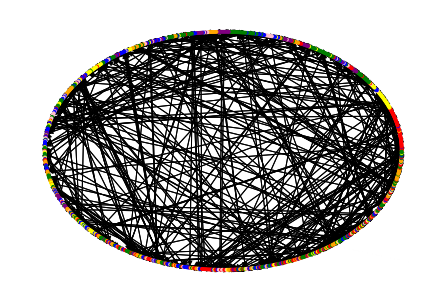

test accuracy:  tensor(0.7560)
Epoch 0
loss = 1.932
current val acc = 0.118, best val acc = 0.118
Epoch 1
loss = 1.916
current val acc = 0.126, best val acc = 0.126
Epoch 2
loss = 1.918
current val acc = 0.176, best val acc = 0.176
Epoch 3
loss = 1.851
current val acc = 0.192, best val acc = 0.192
Epoch 4
loss = 1.863
current val acc = 0.196, best val acc = 0.196
Epoch 5
loss = 1.837
current val acc = 0.216, best val acc = 0.216
Epoch 6
loss = 1.823
current val acc = 0.236, best val acc = 0.236
Epoch 7
loss = 1.794
current val acc = 0.276, best val acc = 0.276
Epoch 8
loss = 1.779
current val acc = 0.284, best val acc = 0.284
Epoch 9
loss = 1.722
current val acc = 0.326, best val acc = 0.326
Epoch 10
loss = 1.718
current val acc = 0.326, best val acc = 0.326
Epoch 11
loss = 1.716
current val acc = 0.340, best val acc = 0.340
Epoch 12
loss = 1.678
current val acc = 0.362, best val acc = 0.362
Epoch 13
loss = 1.656
current val acc = 0.404, best val acc = 0.404
Epoch 14
loss = 1.653
curre

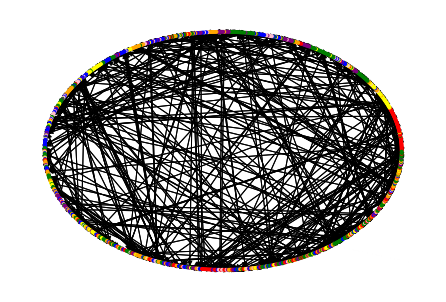

test accuracy:  tensor(0.7510)
Epoch 0
loss = 2.180
current val acc = 0.184, best val acc = 0.184
Epoch 1
loss = 2.180
current val acc = 0.186, best val acc = 0.186
Epoch 2
loss = 2.056
current val acc = 0.188, best val acc = 0.188
Epoch 3
loss = 1.947
current val acc = 0.190, best val acc = 0.190
Epoch 4
loss = 2.034
current val acc = 0.174, best val acc = 0.190
Epoch 5
loss = 1.982
current val acc = 0.162, best val acc = 0.190
Epoch 6
loss = 1.940
current val acc = 0.176, best val acc = 0.190
Epoch 7
loss = 1.922
current val acc = 0.220, best val acc = 0.220
Epoch 8
loss = 1.956
current val acc = 0.212, best val acc = 0.220
Epoch 9
loss = 2.004
current val acc = 0.154, best val acc = 0.220
Epoch 10
loss = 1.937
current val acc = 0.164, best val acc = 0.220
Epoch 11
loss = 1.880
current val acc = 0.156, best val acc = 0.220
Epoch 12
loss = 1.855
current val acc = 0.202, best val acc = 0.220
Epoch 13
loss = 1.896
current val acc = 0.216, best val acc = 0.220
Epoch 14
loss = 1.803
curre

KeyboardInterrupt: 

In [11]:
main(cora_graph, cora_node_features, cora_node_labels, cora_train_mask, cora_valid_mask, cora_test_mask, cora_n_features, cora_n_labels)

Epoch 0
loss = 1.792
current val acc = 0.204, best val acc = 0.204
Epoch 1
loss = 1.787
current val acc = 0.162, best val acc = 0.204
Epoch 2
loss = 1.782
current val acc = 0.192, best val acc = 0.204
Epoch 3
loss = 1.776
current val acc = 0.204, best val acc = 0.204
Epoch 4
loss = 1.771
current val acc = 0.206, best val acc = 0.206
Epoch 5
loss = 1.765
current val acc = 0.204, best val acc = 0.206
Epoch 6
loss = 1.759
current val acc = 0.204, best val acc = 0.206
Epoch 7
loss = 1.753
current val acc = 0.206, best val acc = 0.206
Epoch 8
loss = 1.746
current val acc = 0.214, best val acc = 0.214
Epoch 9
loss = 1.738
current val acc = 0.220, best val acc = 0.220
Epoch 10
loss = 1.731
current val acc = 0.238, best val acc = 0.238
Epoch 11
loss = 1.722
current val acc = 0.256, best val acc = 0.256
Epoch 12
loss = 1.713
current val acc = 0.270, best val acc = 0.270
Epoch 13
loss = 1.704
current val acc = 0.292, best val acc = 0.292
Epoch 14
loss = 1.694
current val acc = 0.308, best val ac

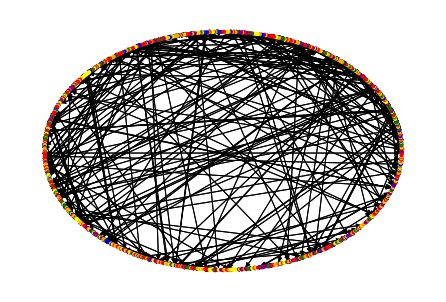

test accuracy:  tensor(0.6270)
Epoch 0
loss = 1.793
current val acc = 0.178, best val acc = 0.178
Epoch 1
loss = 1.777
current val acc = 0.174, best val acc = 0.178
Epoch 2
loss = 1.758
current val acc = 0.266, best val acc = 0.266
Epoch 3
loss = 1.738
current val acc = 0.340, best val acc = 0.340
Epoch 4
loss = 1.706
current val acc = 0.310, best val acc = 0.340
Epoch 5
loss = 1.696
current val acc = 0.338, best val acc = 0.340
Epoch 6
loss = 1.673
current val acc = 0.328, best val acc = 0.340
Epoch 7
loss = 1.645
current val acc = 0.380, best val acc = 0.380
Epoch 8
loss = 1.617
current val acc = 0.404, best val acc = 0.404
Epoch 9
loss = 1.602
current val acc = 0.434, best val acc = 0.434
Epoch 10
loss = 1.591
current val acc = 0.486, best val acc = 0.486
Epoch 11
loss = 1.531
current val acc = 0.504, best val acc = 0.504
Epoch 12
loss = 1.539
current val acc = 0.494, best val acc = 0.504
Epoch 13
loss = 1.496
current val acc = 0.488, best val acc = 0.504
Epoch 14
loss = 1.461
curre

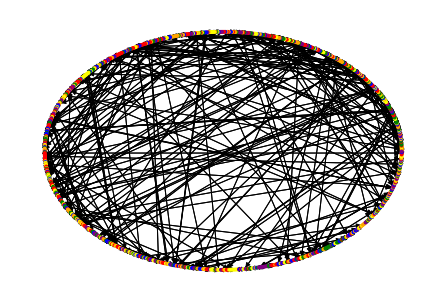

test accuracy:  tensor(0.6460)
Epoch 0
loss = 1.793
current val acc = 0.172, best val acc = 0.172
Epoch 1
loss = 1.791
current val acc = 0.172, best val acc = 0.172
Epoch 2
loss = 1.789
current val acc = 0.172, best val acc = 0.172
Epoch 3
loss = 1.788
current val acc = 0.172, best val acc = 0.172
Epoch 4
loss = 1.786
current val acc = 0.172, best val acc = 0.172
Epoch 5
loss = 1.783
current val acc = 0.176, best val acc = 0.176
Epoch 6
loss = 1.780
current val acc = 0.174, best val acc = 0.176
Epoch 7
loss = 1.776
current val acc = 0.164, best val acc = 0.176
Epoch 8
loss = 1.772
current val acc = 0.142, best val acc = 0.176
Epoch 9
loss = 1.766
current val acc = 0.110, best val acc = 0.176
Epoch 10
loss = 1.759
current val acc = 0.100, best val acc = 0.176
Epoch 11
loss = 1.751
current val acc = 0.086, best val acc = 0.176
Epoch 12
loss = 1.741
current val acc = 0.084, best val acc = 0.176
Epoch 13
loss = 1.729
current val acc = 0.116, best val acc = 0.176
Epoch 14
loss = 1.715
curre

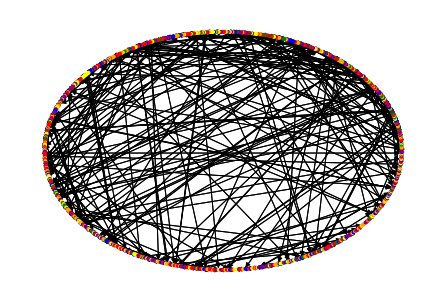

test accuracy:  tensor(0.5150)


In [21]:
main(cite_graph, cite_node_features, cite_node_labels, cite_train_mask, cite_valid_mask, cite_test_mask, cite_n_features, cite_n_labels)

Epoch 0
loss = 1.099
current val acc = 0.322, best val acc = 0.322
Epoch 1
loss = 1.094
current val acc = 0.218, best val acc = 0.322
Epoch 2
loss = 1.090
current val acc = 0.198, best val acc = 0.322
Epoch 3
loss = 1.086
current val acc = 0.196, best val acc = 0.322
Epoch 4
loss = 1.082
current val acc = 0.196, best val acc = 0.322
Epoch 5
loss = 1.078
current val acc = 0.196, best val acc = 0.322
Epoch 6
loss = 1.074
current val acc = 0.196, best val acc = 0.322
Epoch 7
loss = 1.069
current val acc = 0.196, best val acc = 0.322
Epoch 8
loss = 1.065
current val acc = 0.196, best val acc = 0.322
Epoch 9
loss = 1.060
current val acc = 0.196, best val acc = 0.322
Epoch 10
loss = 1.055
current val acc = 0.196, best val acc = 0.322
Epoch 11
loss = 1.050
current val acc = 0.196, best val acc = 0.322
Epoch 12
loss = 1.044
current val acc = 0.196, best val acc = 0.322
Epoch 13
loss = 1.038
current val acc = 0.196, best val acc = 0.322
Epoch 14
loss = 1.032
current val acc = 0.210, best val ac

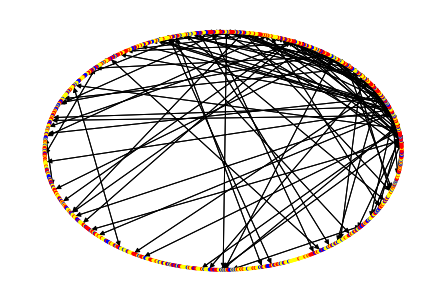

test accuracy:  tensor(0.6930)
Epoch 0
loss = 1.080
current val acc = 0.370, best val acc = 0.370
Epoch 1
loss = 1.092
current val acc = 0.418, best val acc = 0.418
Epoch 2
loss = 1.057
current val acc = 0.426, best val acc = 0.426
Epoch 3
loss = 1.037
current val acc = 0.462, best val acc = 0.462
Epoch 4
loss = 1.028
current val acc = 0.472, best val acc = 0.472
Epoch 5
loss = 0.997
current val acc = 0.468, best val acc = 0.472
Epoch 6
loss = 0.970
current val acc = 0.544, best val acc = 0.544
Epoch 7
loss = 0.946
current val acc = 0.498, best val acc = 0.544
Epoch 8
loss = 0.901
current val acc = 0.560, best val acc = 0.560
Epoch 9
loss = 0.882
current val acc = 0.586, best val acc = 0.586
Epoch 10
loss = 0.860
current val acc = 0.586, best val acc = 0.586
Epoch 11
loss = 0.812
current val acc = 0.552, best val acc = 0.586
Epoch 12
loss = 0.849
current val acc = 0.638, best val acc = 0.638
Epoch 13
loss = 0.767
current val acc = 0.622, best val acc = 0.638
Epoch 14
loss = 0.784
curre

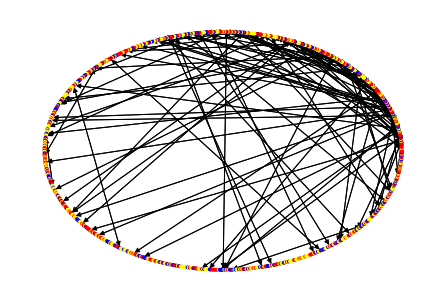

test accuracy:  tensor(0.7400)
Epoch 0
loss = 1.099
current val acc = 0.284, best val acc = 0.284
Epoch 1
loss = 1.095
current val acc = 0.500, best val acc = 0.500
Epoch 2
loss = 1.092
current val acc = 0.532, best val acc = 0.532
Epoch 3
loss = 1.088
current val acc = 0.518, best val acc = 0.532
Epoch 4
loss = 1.084
current val acc = 0.490, best val acc = 0.532
Epoch 5
loss = 1.078
current val acc = 0.464, best val acc = 0.532
Epoch 6
loss = 1.071
current val acc = 0.422, best val acc = 0.532
Epoch 7
loss = 1.063
current val acc = 0.434, best val acc = 0.532
Epoch 8
loss = 1.052
current val acc = 0.464, best val acc = 0.532
Epoch 9
loss = 1.039
current val acc = 0.492, best val acc = 0.532
Epoch 10
loss = 1.024
current val acc = 0.508, best val acc = 0.532
Epoch 11
loss = 1.005
current val acc = 0.506, best val acc = 0.532
Epoch 12
loss = 0.984
current val acc = 0.500, best val acc = 0.532
Epoch 13
loss = 0.958
current val acc = 0.502, best val acc = 0.532
Epoch 14
loss = 0.929
curre

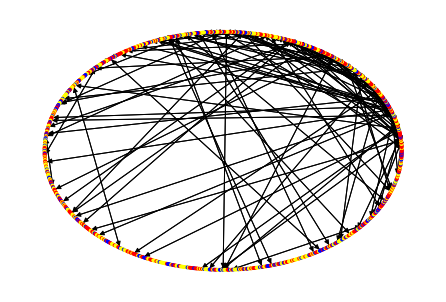

test accuracy:  tensor(0.7320)


In [22]:
main(pubm_graph, pubm_node_features, pubm_node_labels, pubm_train_mask, pubm_valid_mask, pubm_test_mask, pubm_n_features, pubm_n_labels)